In [ ]:
# Import relevant libraries
import ee
# Authenticate GEE and initialize
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
# pip install pandas

In [ ]:
# Import the boundaries of the region of interest
delhi = ee.FeatureCollection("FAO/GAUL/2015/level1") \
            .filter(ee.Filter.eq('ADM1_NAME','Delhi'))
# Import the raster data on aerosol concentration and apply regional filters.
# It vastly improves run time of the code by reducing the number of images in the collection.
asol = ee.ImageCollection("MODIS/006/MCD19A2_GRANULES")\
        .filterBounds(delhi)\
        .filterDate('2000-01-01', '2020-12-31');
# Reduce the image data into a statistic for Delhi
def reduce_del(img):
    stat = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=delhi, scale=1000).get('Optical_Depth_047')
    date = img.date().format()
    mydict = {'date': date, 'stat': stat}
    return ee.Feature(None).set(mydict)
# Convert ImageCollection into FeatureCollection and filter the FeatureCollection keeping only notNull values
reduced_del = ee.FeatureCollection(asol.map(reduce_del)).filter(ee.Filter.notNull(['date','stat']))
# Code for exporting Delhi AOD data to GDrive as a batch process.
task = ee.batch.Export.table.toDrive(
    collection = reduced_del,
    description = 'aod_stat_del',
    folder = 'satellite',
    fileFormat = 'CSV',
    selectors = ['date','stat']
)
task.start()

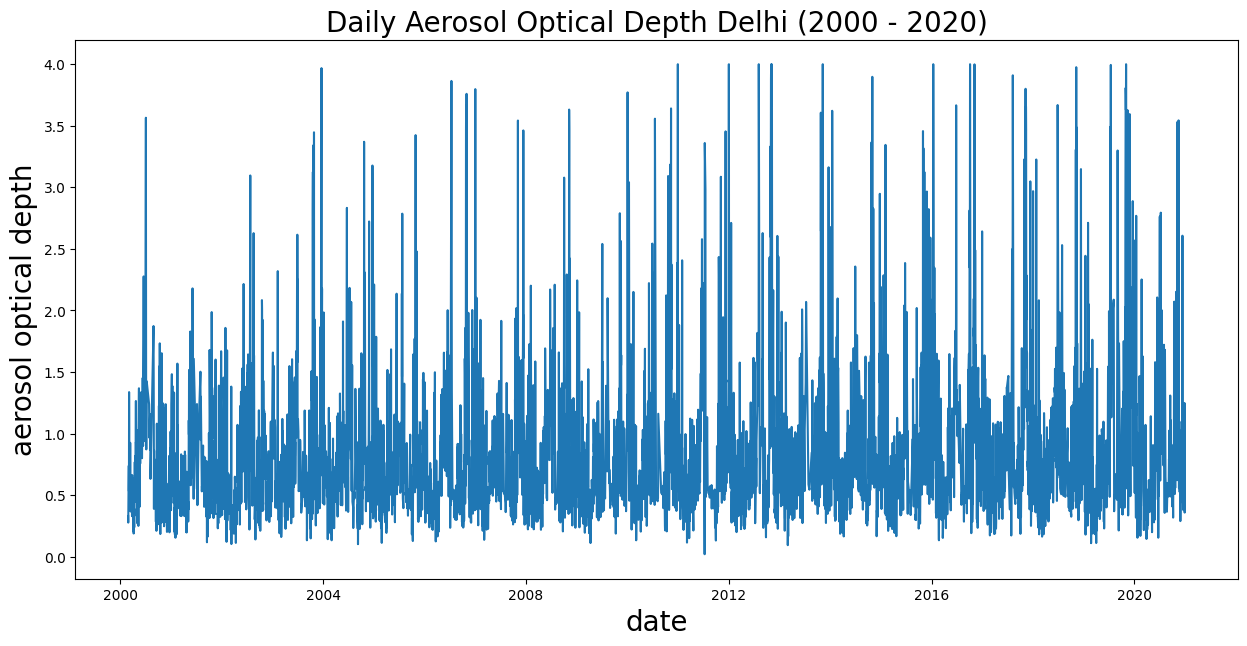

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
aerosoldf = pd.read_csv('aod_stat_del.csv')
# Define a function to transform the dataframe into time series
# Rescale AOD values from 0.001 to 1 by dividing the numbers by 1000.
# Group the observations by day and take the average AOD value
def tseries(df):
    
    df['date_formatted'] = pd.to_datetime(df['date']).dt.normalize()
    
    df.stat = df.stat/1000
    
    df = df.groupby('date_formatted').agg(mean_stat =    pd.NamedAgg(column = 'stat', aggfunc = 'mean'))
    
    return df
aerosoldf = tseries(aerosoldf)
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))
# we'll create the plot by setting our dataframe to the data argument
ax.plot(aerosoldf.index, aerosoldf.mean_stat)
# we'll set the labels and title
ax.set_ylabel('aerosol optical depth',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('Daily Aerosol Optical Depth Delhi (2000 - 2020)',fontsize=20);
plt.show()


https://towardsdatascience.com/tracking-aerosol-pollution-from-space-8ff53bb64d0f

In [ ]:
# Retrieve year information from date index
aerosoldf['year'] = aerosoldf.index.year
#Define AOD threshold as 1 
aerosoldf['threshold'] = 1
#Create a binary column which takes value 1 when AOD exceeds threshold and 0 otherwise
aerosoldf['severe'] = np.where(aerosoldf['mean_stat'] > aerosoldf['threshold'], 1,0)
#Group the observations and count the number of days having severe pollution in each year
aerosol = aerosoldf.groupby('year').agg(obs_days = pd.NamedAgg(column = 'severe', aggfunc = 'count'),
                                        severe_days = pd.NamedAgg(column = 'severe', aggfunc = 'sum'))
# As the number of observed days are not uniform across years, we calculate the percentage of severe days and multiply by 365 to make it comparable across years
aerosol['severe_days_annual'] = aerosol['severe_days'] / aerosol['obs_days'] * 365
aerosol

,obs_days,severe_days,severe_days_annual
year,,,
2000,235,58,90.085106
2001,275,49,65.036364
2002,301,64,77.607973
2003,289,67,84.619377
2004,314,66,76.719745
2005,305,50,59.836066
2006,312,61,71.362179
2007,301,68,82.458472
2008,286,78,99.545455


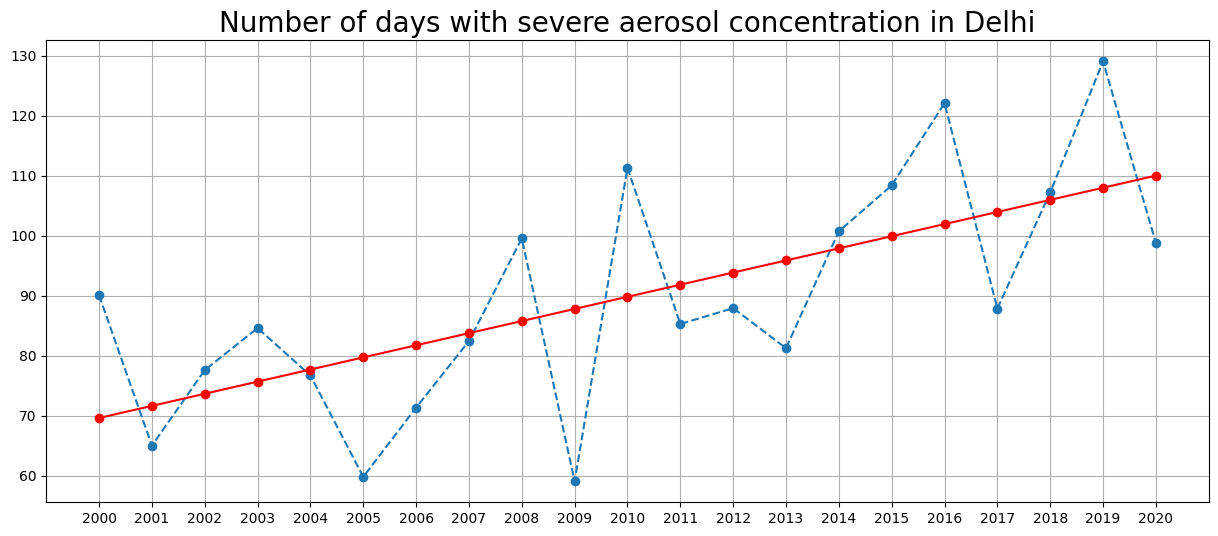

In [ ]:
# Function to find slope and intercept of trendline
def trendline(df):
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['severe_days_annual'])
    
    pct = intercept + slope * df.index
    return(pct)
#Plot
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(aerosol.index.astype(int), aerosol.severe_days_annual, linestyle="dashed", marker = 'o')
ax.plot(aerosol.index.astype(int), trendline(aerosol), color = 'red', marker='o')
ax.set_xticks(range(2000,2021))
# we'll set the labels and title
ax.set_title('Number of days with severe aerosol concentration in Delhi',fontsize=20);
plt.grid()
plt.show()